Using TensorFlow backend.


[('n03877472', 'pajama', 0.0897184),
 ('n04350905', 'suit', 0.035495754),
 ('n02883205', 'bow_tie', 0.033729058),
 ('n02769748', 'backpack', 0.031381227),
 ('n02815834', 'beaker', 0.026813142)]

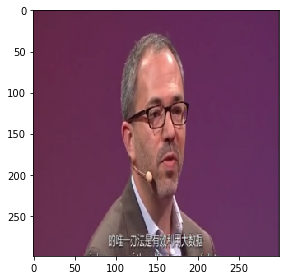

In [2]:
# Read Image
import numpy as np
import skimage
import skimage.io
import skimage.transform
Xi = skimage.io.imread("To_Matrix_test.png")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

#Predict class for image using InceptionV3
import keras
from keras.applications.imagenet_utils import decode_predictions
np.random.seed(222)
inceptionV3_model = keras.applications.inception_v3.InceptionV3() #Load pretrained model
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
top_pred_classes = preds[0].argsort()[-5:][::-1] # Save ids of top 5 classes
decode_predictions(preds)[0] #Print top 5 classes

In [ ]:
#Generate segmentation for image
import skimage.segmentation
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
num_superpixels

In [ ]:
#Generate perturbations
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
import copy
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
print(predictions.shape)

In [ ]:
#Compute distances to original image
import sklearn.metrics
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances.shape)

#Transform distances to a value between 0 an 1 (weights) using a kernel function
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights.shape)

In [ ]:
#Estimate linear model
from sklearn.linear_model import LinearRegression
class_to_explain = top_pred_classes[0] #Labrador class
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]

#Use coefficients from linear model to extract top features
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 

#Show only the superpixels corresponding to the top features
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()                                                            
#每個perturbation視作一個sample, 每個perturbation是一個62維的data point
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights) 
#sample_weight是給每個perturbation, 共150個
coeff = simpler_model.coef_[0]
coeff

In [ ]:
simpler_model.coef_

In [ ]:
coeff.shape

In [ ]:
simpler_model.coef_.shape

In [ ]:
perturbations.shape

In [ ]:
Xi  #as input of the pre-trained model

In [ ]:
image = Xi/2+0.5  #as a image = 0-1
image

In [ ]:
perturb_image(Xi/2+0.5,mask,superpixels)

In [ ]:
perturb_image(Xi/2+0.5,mask,superpixels).shape

In [ ]:
superpixels

In [ ]:
def perturb_image2(mask, segments): 
  active_pixels = top_features
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  return mask

C = perturb_image2(mask, superpixels)
D = np.int64(C)
D

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, D))

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(perturb_image(Xi/2+0.5,mask,superpixels), D))

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, D, color=(1, 0, 0), outline_color=(1, 1, 0)))

In [ ]:
Xi

In [ ]:
image

In [6]:
from lime import lime_image
import time

In [7]:
explainer = lime_image.LimeImageExplainer()

In [8]:
explanation = explainer.explain_instance(Xi[np.newaxis,:,:,:], inceptionV3_model.predict, top_labels=5, hide_color=0, num_samples=1000)

RuntimeError: sequence argument must have length equal to input rank

In [9]:
tmp = time.time()
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(Xi, inceptionV3_model.predict, top_labels=5, hide_color=0, num_samples=1000)
print(time.time() - tmp)


877.7754275798798


In [ ]:
Xi.shape #直接餵給inceptionV3_model.predict需要(batch_size, 299, 299, 3) = Xi[np.newaxis,:,:,:]
         #餵給explainer.explain_instance只需(299, 299, 3) = Xi (非0-1 or 0-255)

In [10]:
from skimage.segmentation import mark_boundaries

In [4]:
#when you call get_image_and_mask, the first parameter is which label you want the explanation for. 
#Since you called explain_instance with top_labels=5, 
#explanation only has the 5 labels with highest predicted probability by the model, 
#and I'm guessing 295 (American black bear) is not one of them.
top_pred_classes[0]

697

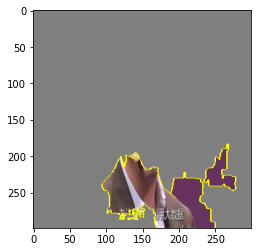

In [12]:
from matplotlib import pyplot as plt
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

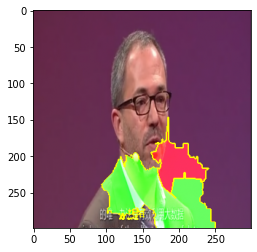

In [20]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

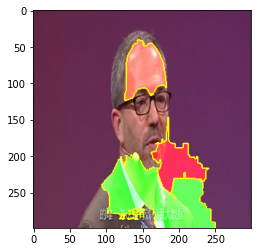

In [14]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=False, num_features=6, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#Does this mean the 6th feature might not be good for predicting top_pred_classes[0]? After that (including it), all are not good?

In [ ]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[0], positive_only=False, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[1], positive_only=False, num_features=7, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(top_pred_classes[1], positive_only=False, num_features=8, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#Does this mean the 8th feature might not be good for predicting top_pred_classes[1]? After that (including it), all are not good?